In [1]:
import numpy as np
from datasets import load_dataset
from pathlib import Path

/workspace/ALGOVERSE/yas/yulia/parascopes/.yulia-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Original dataset path
ORIG_PQ = "yulia-volkova/parascopes-outlines-data@main/v5.0/data/outlines_009.parquet"

# Gemma dataset path
GEMMA_PQ = "yulia-volkova/parascopes-outlines-data-gemma27b@main/v0.0/data/outlines_009.parquet"

# Output directory
OUT_DIR = Path("./eval_outlines_comparison")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Output files
OUT_ORIG_CSV = OUT_DIR / "rubric_original.csv"
OUT_GEMMA_CSV = OUT_DIR / "rubric_gemma.csv"
OUT_SUMMARY_CSV = OUT_DIR / "rubric_score_baseline.csv"


In [ ]:
# Load original dataset and take last 1000, because we are only doing chunk 999
ds_orig = load_dataset("parquet", data_files=f"hf://datasets/{ORIG_PQ}")["train"]
n_orig = len(ds_orig)
tail_orig = ds_orig.select(range(n_orig-1000, n_orig))  # last 1000
df_orig = tail_orig.to_pandas().reset_index(drop=True)
df_orig["index"] = np.arange(1000)  # local 0..999 index
df_orig["model"] = "original"

print("Original dataset shape:", df_orig.shape)
print("Original columns:", df_orig.columns.tolist())


Original dataset shape: (1000, 8)
Original columns: ['example_id', 'dataset_idx', 'model', 'completion', 'outline_generated', 'reconstructed_text', 'embedding_id', 'index']


In [4]:
# Load Gemma dataset and take last 1000
ds_gemma = load_dataset("parquet", data_files=f"hf://datasets/{GEMMA_PQ}")["train"]
n_gemma = len(ds_gemma)
tail_gemma = ds_gemma.select(range(n_gemma-1000, n_gemma))  # last 1000
df_gemma = tail_gemma.to_pandas().reset_index(drop=True)
df_gemma["index"] = np.arange(1000)  # local 0..999 index
df_gemma["model"] = "gemma"

print("Gemma dataset shape:", df_gemma.shape)
print("Gemma columns:", df_gemma.columns.tolist())


Gemma dataset shape: (1000, 8)
Gemma columns: ['example_id', 'dataset_idx', 'model', 'completion', 'outline_generated', 'reconstructed_text', 'embedding_id', 'index']


In [6]:

rubric = """
#### 0. Complexity
How complex is the outline text?
0: Trivial (e.g: just says "** Section **")
1. Simple (e.g: "** Section 1: Green Tea **")
2. Some detail (e.g: a short undetailed sentence or two about something)
3. Many details (e.g: a detailed paragraph with specific information)

#### 1. Coherence (Outline-Level)
Does Outline 2 make sense as an outline compared to Outline 1?
0: Completely incoherent (e.g., excessive repetition, nonsensical phrases, strange symbols).
1: Partially coherent, but repetitive or has formatting issues (e.g., repeated key phrases, awkward pauses).
2: Mostly coherent with minor grouping/order issues.
3: Clear, logical, coherent outline structure.

#### 2. Hierarchy / Structure
How well does Outline 2 preserve the hierarchical levels (headings vs sub-bullets)?
0: No recognizable hierarchy; flat or malformed.
1: Basic levels exist but often mis-nested.
2: Mostly correct hierarchy with some mismatches.
3: Hierarchy closely matches with minimal deviations, highly similar structure.

#### 3. Coverage of Key Sections
Do the major sections in Outline 1 appear in Outline 2?
0: Most key sections missing or unrelated.
1: About half of major sections appear.
2: Most sections present; minor omissions.
3: All major sections present (allow synonyms/regrouping).

#### 4. Ordering / Flow
Does the order of major sections and sub-sections follow Outline 1?
0: Largely shuffled or illogical.
1: Partial overlap but frequent swaps.
2: Mostly consistent with minor swaps.
3: Order closely matches.

#### 5. Subject Match
How similar is the subject of Outline 2 to Outline 1?
-1: No subjects to compare.
0: Completely unrelated subjects ("corporate law" vs "particle physics")
1: Vaguely similar field (e.g: "biology" vs "physics" are both sciences)
2: Related general domain or adjacent fields (e.g., "history" vs. "archaeology" or "alternative medicine" vs. "traditional remedies").
3: Same subject (e.g., both discuss "ancient mayans" or "the properties of the human body").
4: Identical focus (e.g., both analyze "ancient mayan architecture").

#### 6. Entities / Key Concepts
How well does Outline 2 preserve entities or technical terms from Outline 1?
-1: No entities to compare.
0: Unrelated entities.
1: Same category but little overlap.
2: Some overlap or synonyms.
3: Most entities/terms preserved.
4: Nearly all preserved.

#### 7. Details
How similar are the details in the response (Outline 2) to the reference (Outline 1)?
-1: Neither outline text has details to compare.
0: Details differ completely (e.g., Outline 1 lists benefits; Outline 2 is generic).
1: Minimal depth (e.g., both mention "anti-inflammatory properties" with no specifics).
2: Moderate depth (e.g., discuss benefits + 1-2 supporting facts).
3: Highly specific details (e.g., "40% reduction in inflammation").

#### 8. Conciseness of Headings
Are headings concise and outline-appropriate (not full sentences)?
0: Often verbose, unclear, or sentence-like.
1: Mixed clarity—some concise, some verbose.
2: Mostly concise, descriptive headings.

#### 9. Identical
Is Outline 2 essentially identical to Outline 1 (ignoring trivial formatting)?
0: Not identical.
1: Identical.
---

JSON output: {
    "reasoning": {complexity, coherence, hierarchy, coverage, ordering, subject, entities, details, conciseness, identical} - each with explanation string
    "scoring":  {Same keys as above} - each with number score
}

Reasoning should be concise, and explicitly state the "name" of the level (such
as for entities: "[reasoning about the texts], Thus: similar category and partial identical entities: thus out of 4, score 3").

If the specific category does not apply to many things (e.g: complexity is 0 or
1), and there is no specifics between either, then by default give full points.
"""

json_schema = {
    "type": "object",
    "properties": {
        "reasoning": {
            "complexity": {"type": "string"},
            "coherence": {"type": "string"},
            "hierarchy": {"type": "string"},
            "coverage": {"type": "string"},
            "ordering": {"type": "string"},
            "subject": {"type": "string"},
            "entities": {"type": "string"},
            "details": {"type": "string"},
            "conciseness": {"type": "string"},
            "identical": {"type": "string"},
        },
        "scoring": {
            "complexity": {"type": "integer", "minimum": 0, "maximum": 3},
            "coherence": {"type": "integer", "minimum": 0, "maximum": 3},
            "hierarchy": {"type": "integer", "minimum": 0, "maximum": 3},
            "coverage": {"type": "integer", "minimum": 0, "maximum": 3},
            "ordering": {"type": "integer", "minimum": 0, "maximum": 3},
            "subject": {"type": "integer", "minimum": -1, "maximum": 4},
            "entities": {"type": "integer", "minimum": -1, "maximum": 4},
            "details": {"type": "integer", "minimum": -1, "maximum": 3},
            "conciseness": {"type": "integer", "minimum": 0, "maximum": 2},
            "identical": {"type": "integer", "minimum": 0, "maximum": 1},
        },
    },
    "required": ["reasoning", "scoring"],
}


In [ ]:
import json, numpy as np, pandas as pd
from typing import List
from openai import OpenAI
import sys
from utils_parallel import exponential_backoff, process_in_parallel

@exponential_backoff
def ruberic_compare(ref_text: str, comp_text: str):
    """
    Call the LLM to compare two outlines using the rubric and return JSON (as text).
    """
    prompt = (
        f"Using the following rubric, compare the two outlines:\n\n"
        f"Rubric: {rubric}\n\n"
        f"Outline 1 (reference): {ref_text}\n\n"
        f"Outline 2 (candidate): {comp_text}\n\n"
        "The output must be a valid JSON object and nothing else."
    )

    client = OpenAI(api_key="")

    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[{
            "role": "user",
            "content": "You are an expert evaluator.\n\n" + prompt
        }],
        temperature=0.3,
        max_tokens=4000,
        response_format={"type": "json_object"}  # enforce JSON
    )

    return response.choices[0].message.content

def get_ruberic_parallel(ref_texts: List[str], comp_texts: List[str], dataset_idxs: List[int], label=None, max_workers: int = 20):
    items = list(zip(np.arange(len(ref_texts)), ref_texts, comp_texts, dataset_idxs))
    print(f"Processing {len(items)} comparisons in parallel")

    def get_rubric(item):
        index, ref_text, comp_text, ds_idx = item
        result = ruberic_compare(ref_text, comp_text)
        print({
            "index": index,
            "dataset_idx": ds_idx,
            "label": label,
            "reference": ref_text,
            "comparison": comp_text,
            "result": result
        })
        sys.stdout.flush()
        return result

    results = process_in_parallel(items, get_rubric, max_workers=max_workers)
    return results

def evaluate_outlines_df(
    df_merged: pd.DataFrame,
    ref_col: str = "outline_generated",
    cand_col: str = "outline_generated",
    out_csv: str = "outline_eval_with_rubric_baseline.csv",
    parallel_workers: int = 20,
) -> pd.DataFrame:
    """
    Runs rubric evaluation on df_merged[ref_col] vs df_merged[cand_col],
    stores raw JSON + parsed scores into columns, and saves a CSV.
    """
    assert ref_col in df_merged.columns and cand_col in df_merged.columns, \
        f"DataFrame must have columns '{ref_col}' and '{cand_col}'"

    ref_texts  = df_merged[ref_col].astype(str).tolist()
    comp_texts = df_merged[cand_col].astype(str).tolist()

    # get JSON strings (one per row)
    raw_results = get_ruberic_parallel(ref_texts, comp_texts, df_merged["index"].tolist(), label=df_merged["model"].iloc[0], max_workers=parallel_workers)

    # attach raw JSON and parsed scores
    df_out = df_merged.copy()
    df_out["rubric_json"] = raw_results

    # parse and expand scores
    def _safe_load(js):
        try:
            return json.loads(js)
        except Exception:
            return {}

    parsed = [ _safe_load(s) for s in raw_results ]
    # add each score as its own column
    score_keys = list(json_schema["properties"]["scoring"].keys())
    for k in score_keys:
        df_out[f"score_{k}"] = [p.get("scoring", {}).get(k, None) for p in parsed]

    # optional: add a total/average score
    # here we sum available scores (treat missing as NaN and skip)
    df_out["score_sum"] = df_out[[f"score_{k}" for k in score_keys]].apply(
        lambda r: np.nansum([float(x) if x is not None else np.nan for x in r.values]), axis=1
    )
    df_out["score_mean"] = df_out[[f"score_{k}" for k in score_keys]].apply(
        lambda r: np.nanmean([float(x) if x is not None else np.nan for x in r.values]), axis=1
    )

    df_out.to_csv(out_csv, index=False)
    print(f"Saved rubric evaluation to: {out_csv}")
    return df_out


In [ ]:

# Create a comparison DataFrame with original outlines as reference
df_compare = df_gemma.copy()
df_compare["reference_outline"] = df_orig["outline_generated"].values  # Add reference outlines

df_scored = evaluate_outlines_df(
    df_compare,
    ref_col="reference_outline",  
    cand_col="outline_generated", 
    out_csv=OUT_SUMMARY_CSV,
    parallel_workers=20,
)

print("\nMean scores for Gemma vs Original:")
score_cols = [c for c in df_scored.columns if c.startswith("score_")]
print(df_scored[score_cols].mean().round(3))


Processing 1000 comparisons in parallel
{'index': 11, 'dataset_idx': 11, 'label': 'gemma', 'reference': 'Outline:\n1. GMO benefits\n   - Increased crop yields\n   - Improved nutrition\n2. GMO concerns\n   - Safety and environmental risks\n   - Unintended effects on health\n3. Scientific consensus\n   - Decades of research show safety\n   - Regulatory approvals\n4. Societal and economic factors\n   - Corporate influence and control\n   - Impact on traditional farming\n5. Future of food and GMOs\n   - Precision agriculture movement\n   - Need for inclusive dialogue', 'comparison': 'Outline:\n1. Introduction to GMO debate\n   - Complexity of the issue\n   - Interplay of science, health, and environment\n2. Science behind GMOs\n   - Genetic modification process\n   - Benefits of GMOs (yield, nutrition, reduced pesticides)\n3. Public perception and concerns\n   - Safety and allergenicity fears\n   - Corporate control and patent issues\n4. Environmental impacts\n   - Effects on biodiversity 

KeyboardInterrupt: 

{'index': 76, 'dataset_idx': 76, 'label': 'gemma', 'reference': 'Outline:\n1. Importance of spatial skills in engineering\n   - Essential for designing and troubleshooting\n2. Challenges in retaining spatial skills\n   - Leading to poor academic performance\n3. Benefits of targeted spatial skills training\n   - Improves student success and retention\n4. Integration of spatial skills training\n   - Into existing engineering curricula\n5. Prioritizing spatial skills training\n   - Equips next generation of engineers', 'comparison': 'Outline:\n1. Spatial skills crucial for engineering success\n   - Linked to student retention\n   - Vital for understanding complex systems\n2. Definition of spatial skills\n   - Spatial visualization and orientation\n   - Perceptual speed\n3. Spatial skills can be improved\n   - Targeted training and practice\n   - Simple exercises and games\n4. Benefits of spatial skills training\n   - Improved academic performance\n   - Increased student confidence\n5. Imp

In [9]:
def print_rubric_statistics(df, title):
    print("=" * 80)
    print(f"DETAILED RUBRIC STATISTICS - llama 70B outline VS gemma 27b outline")
    print("=" * 80)
    
    print(f"\nSample Size: {len(df)} outline pairs")
    
    # Total score statistics
    print("\nTotal Score Statistics (sum of all rubric categories):")
    print(f"Average Total Score: {df['score_sum'].mean():.2f}")
    print(f"Max Total Score: {df['score_sum'].max():.2f}")
    print(f"Min Total Score: {df['score_sum'].min():.2f}")
    print(f"Standard Deviation: {df['score_sum'].std():.2f}")
    
    max_scores = {
        'score_complexity': 3,
        'score_coherence': 3,
        'score_hierarchy': 3,
        'score_coverage': 3,
        'score_ordering': 3,
        'score_subject': 4,
        'score_entities': 4,
        'score_details': 3,
        'score_conciseness': 2,
        'score_identical': 1
    }
    
    # Get score columns excluding sum and mean
    score_cols = [col for col in df.columns if col.startswith('score_') 
                  and col not in ['score_sum', 'score_mean']]
    
    print("\nRubric Category Statistics:")
    print("-" * 60)
    print(f"{'Category':<20} {'Average':<10} {'Max':<10} {'% of Max':<10}")
    print("-" * 60)
    
    category_stats = []
    for col in score_cols:
        avg_score = df[col].mean()
        max_score = df[col].max()
        max_possible = max_scores[col]
        percent_of_max = (avg_score / max_possible) * 100
        
        category_stats.append({
            'category': col.replace('score_', ''),
            'average': avg_score,
            'max': max_score,
            'percent_of_max': percent_of_max
        })
        
        print(f"{col.replace('score_', ''):<20} {avg_score:>8.2f}  {max_score:>8.2f}  {percent_of_max:>8.1f}%")
    
    print("\nTop 3 Best Performing Categories (by % of max possible score):")
    print("-" * 60)
    sorted_stats = sorted(category_stats, key=lambda x: x['percent_of_max'], reverse=True)
    for i, stat in enumerate(sorted_stats[:3], 1):
        print(f"{i}. {stat['category']:<20} ({stat['percent_of_max']:.1f}% of max possible score)")
    
    print("\nTop 3 Categories by Absolute Score:")
    print("-" * 60)
    sorted_by_score = sorted(category_stats, key=lambda x: x['average'], reverse=True)
    for i, stat in enumerate(sorted_by_score[:3], 1):
        print(f"{i}. {stat['category']:<20} (avg score: {stat['average']:.2f})")
    
    print("\nDistribution of Total Scores:")
    print("-" * 60)
    percentiles = [0, 25, 50, 75, 100]
    for p in percentiles:
        score = np.percentile(df['score_sum'], p)
        print(f"{p}th percentile: {score:.2f}")

print_rubric_statistics(df_scored, "Llama 70B vs Gemma 27B Comparison")


NameError: name 'df_scored' is not defined

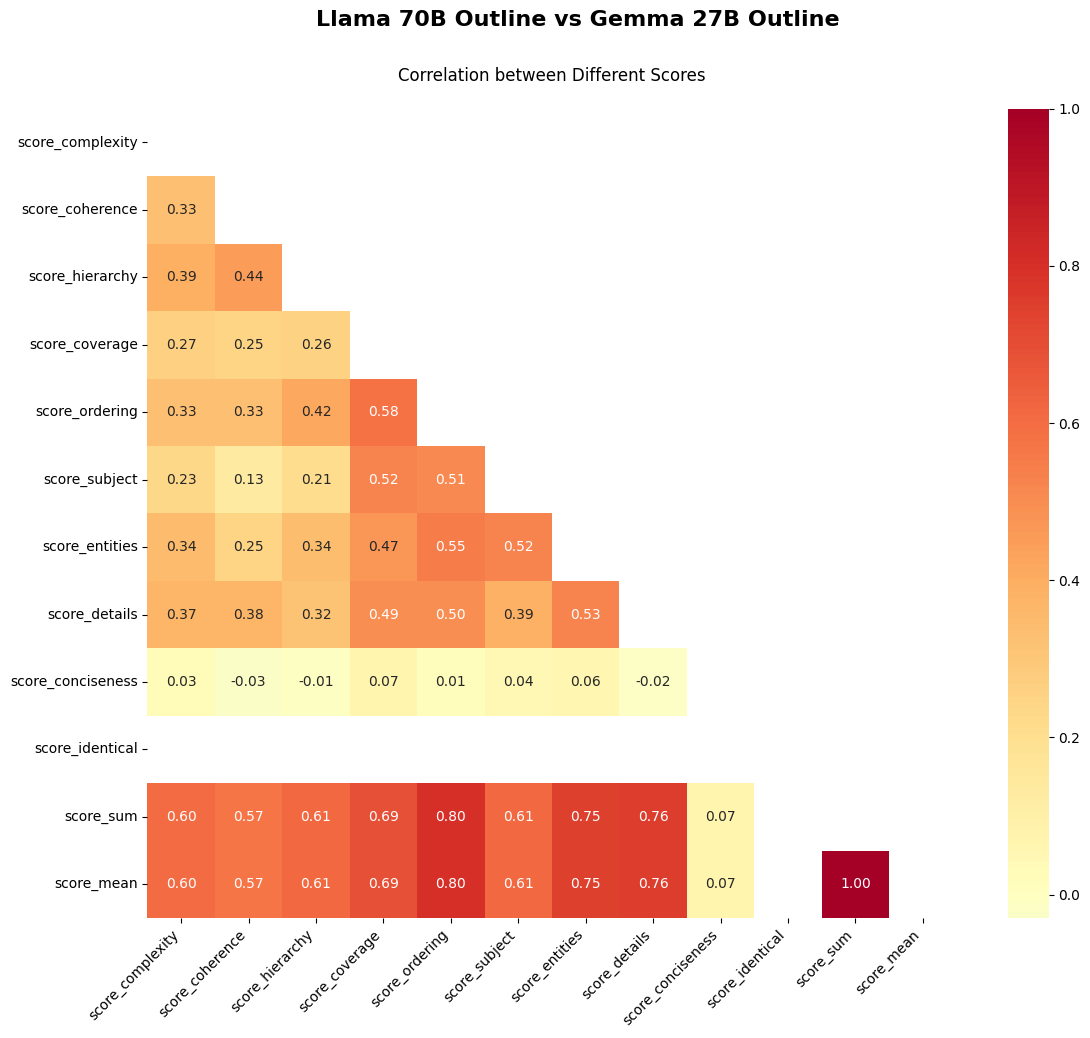

/tmp/ipykernel_796636/2662147724.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variable', y='value', data=score_data, palette=palette)


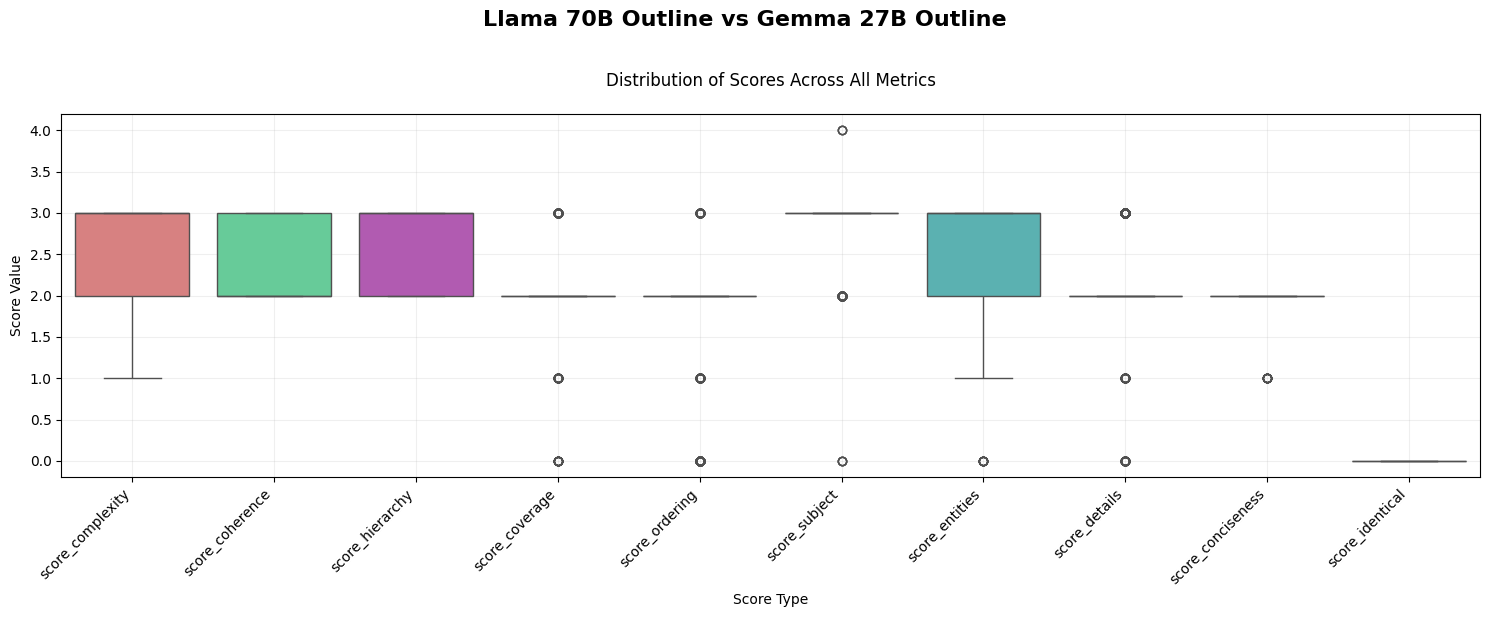

/tmp/ipykernel_796636/2662147724.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='variable', y='value', data=score_data, palette=palette, inner=None, alpha=0.6)


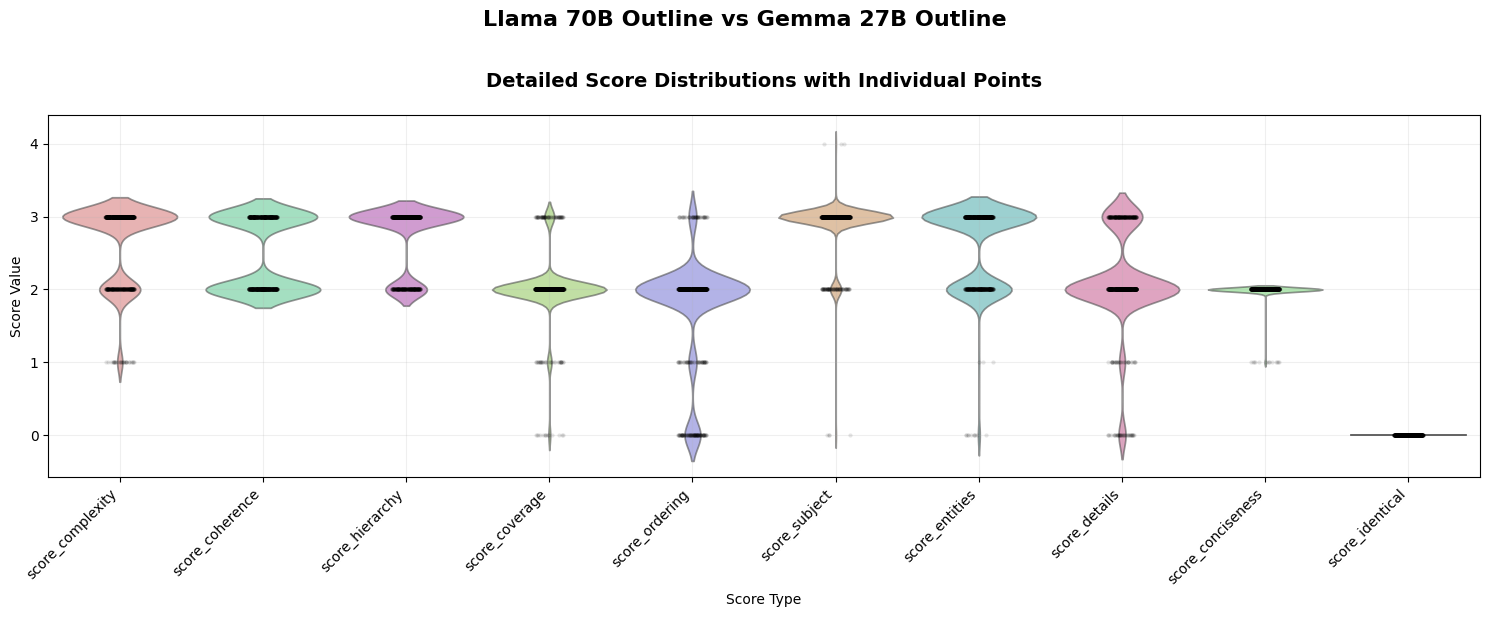


Summary Statistics for Each Score:
       score_complexity  score_coherence  score_hierarchy  score_coverage  score_ordering  score_subject  score_entities  score_details  score_conciseness  score_identical  score_sum  score_mean
count          1000.000         1000.000         1000.000        1000.000        1000.000       1000.000        1000.000       1000.000           1000.000           1000.0   1000.000    1000.000
mean              2.681            2.486            2.734           2.013           1.780          2.902           2.605          2.123              1.987              0.0     21.311       2.131
std               0.531            0.500            0.442           0.406           0.704          0.344           0.553          0.656              0.113              0.0      2.849       0.285
min               1.000            2.000            2.000           0.000           0.000          0.000           0.000          0.000              1.000              0.0      8.000  

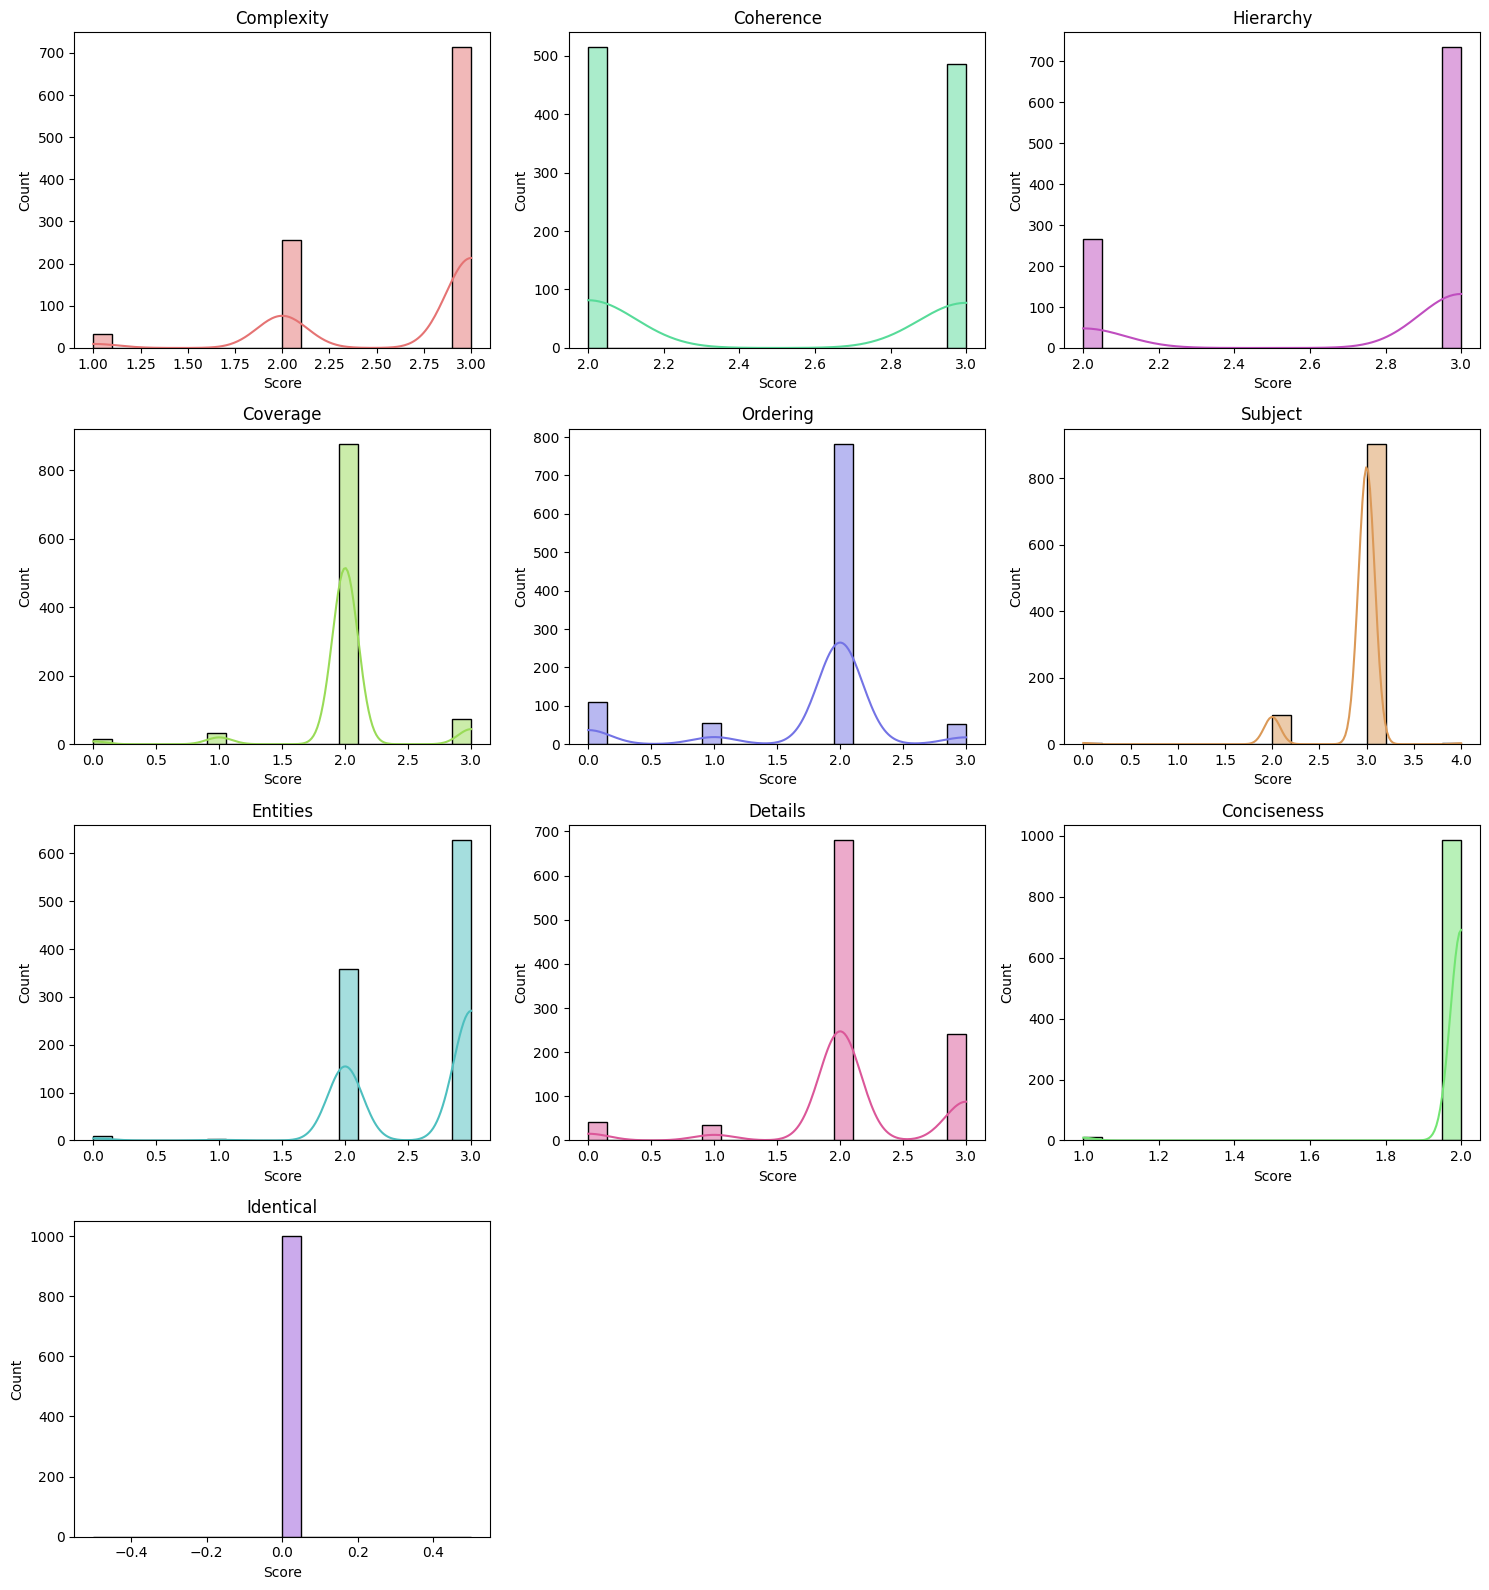

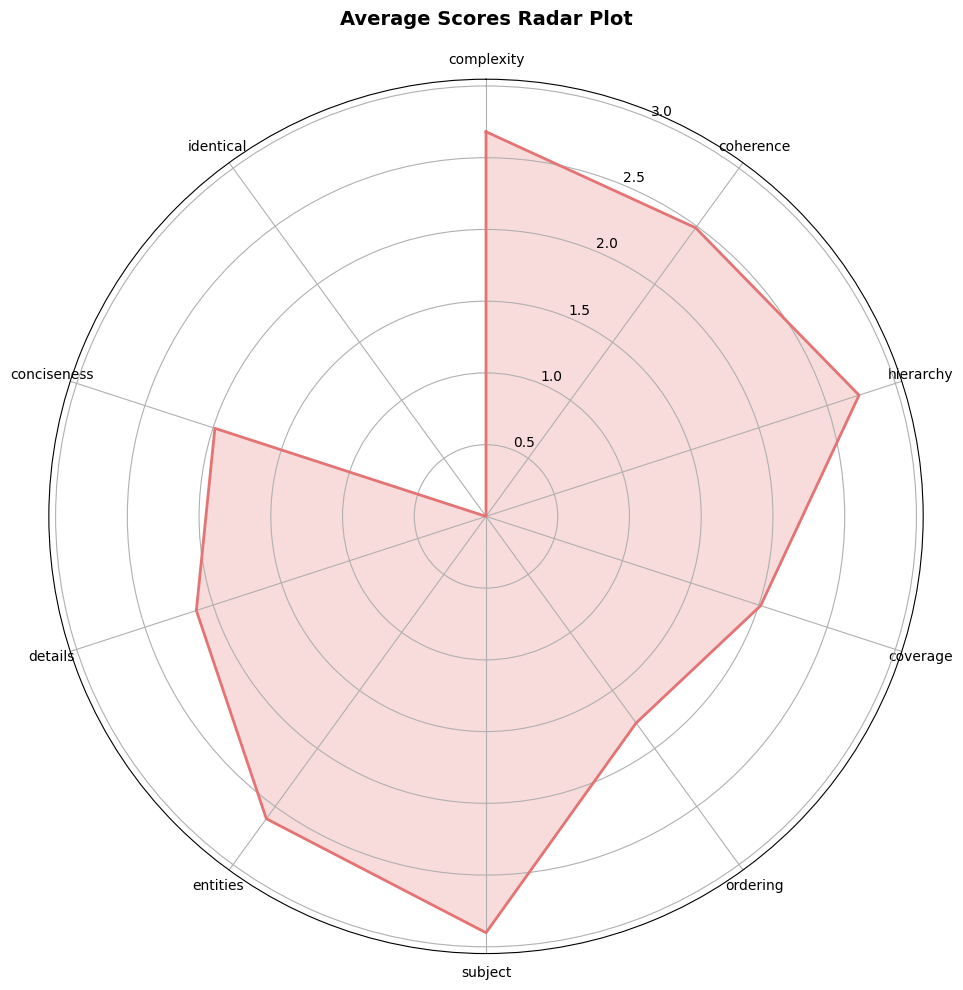


Interesting Statistics:
Highest scoring metric: score_subject (avg: 2.90)
Lowest scoring metric: score_identical (avg: 0.00)

Metrics with highest variance:
score_ordering      0.496096
score_details       0.430301
score_entities      0.305280
score_complexity    0.281521
score_coherence     0.250054


In [ ]:
# visualizations for the scores
import seaborn as sns

# custom color palette function
def get_color(i, total=1):
    hue = i * 150 % 360
    r = 0.6 + 0.3 * np.cos(np.radians(hue))
    g = 0.6 + 0.3 * np.cos(np.radians(hue - 120))
    b = 0.6 + 0.3 * np.cos(np.radians(hue + 120))
    return (r, g, b)

# Create color palette for all metrics
score_cols = [col for col in df_scored.columns if col.startswith('score_')]
score_metrics = [col for col in score_cols if col not in ['score_sum', 'score_mean']]
palette = {metric: get_color(i, len(score_metrics)) for i, metric in enumerate(score_metrics)}


# Box plots for all individual scores
plt.figure(figsize=(15, 6))
score_data = df_scored[score_metrics].melt()
sns.boxplot(x='variable', y='value', data=score_data, palette=palette)
plt.xticks(rotation=45, ha='right')
plt.suptitle('Llama 70B Outline vs Gemma 27B Outline', y=1.02, fontsize=16, fontweight='bold')
plt.title('Distribution of Scores Across All Metrics', pad=20, fontsize=12)
plt.xlabel('Score Type')
plt.ylabel('Score Value')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Violin plots with individual points
plt.figure(figsize=(15, 6))
sns.violinplot(x='variable', y='value', data=score_data, palette=palette, inner=None, alpha=0.6)
sns.stripplot(x='variable', y='value', data=score_data, color='black', alpha=0.1, size=3)
plt.xticks(rotation=45, ha='right')
plt.suptitle('Llama 70B Outline vs Gemma 27B Outline', y=1.02, fontsize=16, fontweight='bold')

plt.title('Detailed Score Distributions with Individual Points', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Score Type')
plt.ylabel('Score Value')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Summary statistics
print(df_scored[score_cols].describe().round(3).to_string())

# Histogram grid for all scores
n_cols = 3
n_rows = (len(score_metrics) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 4*n_rows))
for i, metric in enumerate(score_metrics, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_scored[metric], bins=20, kde=True, color=palette[metric])
    plt.title(metric.replace('score_', '').title())
    plt.xlabel('Score')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


# Print interesting findings
print("\nInteresting Statistics:")
print(f"Highest scoring metric: {score_metrics[values[:-1].index(max(values[:-1]))]} (avg: {max(values[:-1]):.2f})")
print(f"Lowest scoring metric: {score_metrics[values[:-1].index(min(values[:-1]))]} (avg: {min(values[:-1]):.2f})")
print("\nMetrics with highest variance:")
variances = df_scored[score_metrics].var().sort_values(ascending=False)
print(variances.head().to_string())
